# OCR Cookbook

---

## Apply OCR to Convert Images into Text

Optical Character Recognition (OCR) allows you to retrieve text data from images. With Mistral OCR, you can do this extremely fast and effectively, extracting text from hundreds and thousands of images (or PDFs).

In this simple cookbook, we will extract text from a set of images using two methods:
- [Without Batch Inference](#scrollTo=qmXyB3rPlXQW): Looping through the dataset, extracting text from each image, and saving the result.
- [With Batch Inference](#scrollTo=jYfWYjzTmixB): Leveraging Batch Inference to extract text with a 50% cost reduction.

---

### Used

- OCR
- Batch Inference

### Setup
First, let's install `mistralai` and `datasets`

In [43]:
!pip3 install mistralai datasets

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


We can now set up our client. You can create an API key on our [Plateforme](https://console.mistral.ai/api-keys/).

In [ ]:
from mistralai import Mistral

api_key = "YOUR_API_KEY"
client = Mistral(api_key=api_key)
ocr_model = "mistral-ocr-latest"

## Without Batch

As an example, let's use Mistral OCR to extract text from multiple images.

We will use a dataset containing raw image data. To send this data via an image URL, we need to encode it in base64. For more information, please visit our [Vision Documentation](https://docs.mistral.ai/capabilities/vision/#passing-a-base64-encoded-image).

In [45]:
import base64
from io import BytesIO

def encode_image_data(image_data):
    try:
        # Ensure image_data is bytes
        if isinstance(image_data, bytes):
            # Directly encode bytes to base64
            return base64.b64encode(image_data).decode('utf-8')
        else:
            # Convert image data to bytes if it's not already
            buffered = BytesIO()
            image_data.save(buffered, format="JPEG")
            return base64.b64encode(buffered.getvalue()).decode('utf-8')
    except Exception as e:
        print(f"Error encoding image: {e}")
        return None

For this demo, we will use a simple dataset containing numerous documents and scans in image format. Specifically, we will use the `stochastic/random_streetview_images_pano_v0.0.2` dataset, loaded via the `datasets` library.

We will download only 100 samples for this demonstration.

In [46]:
from datasets import load_dataset

n_samples = 100
dataset = load_dataset("stochastic/random_streetview_images_pano_v0.0.2", split="train", streaming=True)
subset = list(dataset.take(n_samples))

With our subset of 100 samples ready, we can loop through each image to extract the text.

We will save the results in a new dataset and export it as a JSONL file.

In [47]:
from tqdm import tqdm

ocr_dataset = []
for sample in tqdm(subset):
    image_data = sample['image']  # 'image' contains the actual image data

    # Encode the image data to base64
    base64_image = encode_image_data(image_data)
    image_url = f"data:image/jpeg;base64,{base64_image}"

    # Process the image using Mistral OCR
    response = client.ocr.process(
        model=ocr_model,
        document={
            "type": "image_url",
            "image_url": image_url,
        }
    )

    # Store the image data and OCR content in the new dataset
    ocr_dataset.append({
        'image': base64_image,
        'ocr_content': response.pages[0].markdown # Since we are dealing with single images, there will be only one page
    })

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


In [48]:
import json

with open('ocr_dataset.json', 'w') as f:
    json.dump(ocr_dataset, f, indent=4)

Perfect, we have extracted all text from the 100 samples. However, this process can be made more cost-efficient using Batch Inference.

## With Batch

To use Batch Inference, we need to create a JSONL file containing all the image data and request information for our batch.

Let's create a function called `create_batch_file` to handle this task by generating a file in the proper format.

In [49]:
def create_batch_file(image_urls, output_file):
    with open(output_file, 'w') as file:
        for index, url in enumerate(image_urls):
            entry = {
                "custom_id": str(index),
                "body": {
                    "document": {
                        "type": "image_url",
                        "image_url": url
                    },
                    "include_image_base64": True
                }
            }
            file.write(json.dumps(entry) + '\n')

The next step involves encoding the data of each image into base64 and saving the URL of each image that will be used.

In [50]:
image_urls = []
for sample in tqdm(subset):
    image_data = sample['image']  # 'image' contains the actual image data

    # Encode the image data to base64 and add the url to the list
    base64_image = encode_image_data(image_data)
    image_url = f"data:image/jpeg;base64,{base64_image}"
    image_urls.append(image_url)

100%|██████████| 100/100 [00:00<00:00, 297.22it/s]


We can now create our batch file.

In [51]:
batch_file = "batch_file.jsonl"
create_batch_file(image_urls, batch_file)

With everything ready, we can upload it to the API.

In [52]:
batch_data = client.files.upload(
    file={
        "file_name": batch_file,
        "content": open(batch_file, "rb")},
    purpose = "batch"
)

The file is uploaded, but the batch inference has not started yet. To initiate it, we need to create a job.

In [53]:
created_job = client.batch.jobs.create(
    input_files=[batch_data.id],
    model=ocr_model,
    endpoint="/v1/ocr",
    metadata={"job_type": "testing"}
)

Our batch is ready and running!

We can retrieve information using the following method:

In [55]:
retrieved_job = client.batch.jobs.get(job_id=created_job.id)
print(f"Status: {retrieved_job.status}")
print(f"Total requests: {retrieved_job.total_requests}")
print(f"Failed requests: {retrieved_job.failed_requests}")
print(f"Successful requests: {retrieved_job.succeeded_requests}")
print(
    f"Percent done: {round((retrieved_job.succeeded_requests + retrieved_job.failed_requests) / retrieved_job.total_requests, 4) * 100}%"
)

Status: SUCCESS
Total requests: 100
Failed requests: 0
Successful requests: 100
Percent done: 100.0%


Let's automate this feedback loop and download the results once they are ready!

In [56]:
import time
from IPython.display import clear_output

while retrieved_job.status in ["QUEUED", "RUNNING"]:
    retrieved_job = client.batch.jobs.get(job_id=created_job.id)

    clear_output(wait=True)  # Clear the previous output ( User Friendly )
    print(f"Status: {retrieved_job.status}")
    print(f"Total requests: {retrieved_job.total_requests}")
    print(f"Failed requests: {retrieved_job.failed_requests}")
    print(f"Successful requests: {retrieved_job.succeeded_requests}")
    print(
        f"Percent done: {round((retrieved_job.succeeded_requests + retrieved_job.failed_requests) / retrieved_job.total_requests, 4) * 100}%"
    )
    time.sleep(2)

b'{"id":"batch-aad03f11-20-893285de-f857-4a97-a188-cd21fb233f39","custom_id":"20","response":{"status_code":200,"body":{"pages":[{"index":0,"markdown":"\\n","images":[],"dimensions":{"dpi":200,"height":561,"width":3030}}],"model":"mistral-ocr-2503-completion","usage_info":{"pages_processed":1,"doc_size_bytes":193321}}},"error":null}\n{"id":"batch-aad03f11-21-ba503a3a-d386-4d1b-997d-997d8146da65","custom_id":"21","response":{"status_code":200,"body":{"pages":[{"index":0,"markdown":"\\n","images":[],"dimensions":{"dpi":200,"height":561,"width":3030}}],"model":"mistral-ocr-2503-completion","usage_info":{"pages_processed":1,"doc_size_bytes":299513}}},"error":null}\n{"id":"batch-aad03f11-22-55ab9a20-22da-427d-aeb6-5bb253e5c18a","custom_id":"22","response":{"status_code":200,"body":{"pages":[{"index":0,"markdown":"\\n","images":[],"dimensions":{"dpi":200,"height":561,"width":3030}}],"model":"mistral-ocr-2503-completion","usage_info":{"pages_processed":1,"doc_size_bytes":211179}}},"error":nul
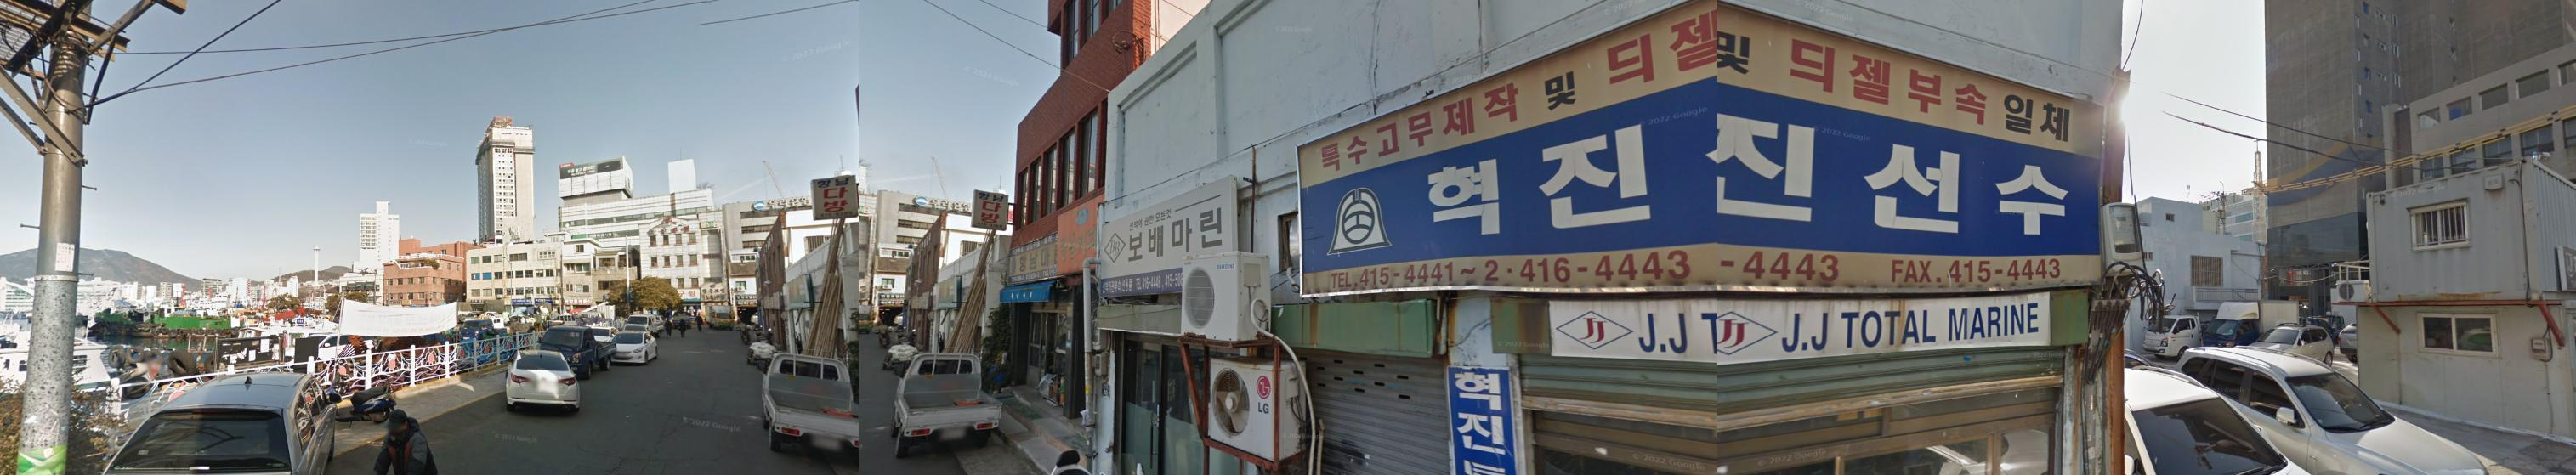

In [ ]:
output_file = client.files.download(file_id=retrieved_job.output_file)

print(output_file.read())

with open('file.jsonl', 'wb') as f:
    f.write(output_file.read())

Done! With this method, you can perform OCR tasks in bulk in a very cost-effective way.